# Etapa I

Infelizmente se encontra no Brasil uma situação bastante desconfortável, o endividamento; segundo dados da CNC o endividamento chega a um recorde 71,4% dos brasileiros. Como forma de contornar essa situação, grande parte das pessoas busca uma solução nos empréstimos, mas qual a garantia que esses 71,4% das pessoas conseguirão pagar seus empréstimos?

E esse é justamente o objetivo deste trabalho, fornecer um meio de previsão para o pagamento de empréstimos, levando em conta alguns fatores como:
*   A idade do solicitante
*   O nível de escolaridade 
*   O período em que o empréstimo está sendo solicitado

Para que seja possível alcançar o obetivo proposto será utilizado a base de dados fornecida pela IBM de empréstimos a pessoas fícticias acrescida de mais alguns dados que condizem com a realidade brasileira. Esse banco de dados se encontra em formato .csv, entretando, tendo as informações necessárias, outros formatos podem ser aplicados, sendo necessário apenas algumas pequenas modificações nas linhas inicias do código.

Devido a forma que os dados são fornecidos é necessário uma série de pré-processamentos, dois quais destacam-se a mudança de variáveis categóricas para númericas, exclusão de outliers e definições de conjuntos para melhor visualização e processamento.

Utilizando os métos KNN, Árvore de decisão, SVM (Support Vector Machines) e regressão lineares e logísticas espera-se obter um modelo de previsão que nos diga se o empréstimo será ou não pago por um solicitante a partir de algumas informações solicitadas.  

# Etapa II

Essa etapa é a responsável pela preparação dos dados, na qual serão aplicados os métodos de pré-processamento na base de dados utilizada e realizada a distribuição dos dados utilizando treino/teste e cross-validation.

## Importando as bibliotecas necessárias para todas as operações adiantes

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

## Fazendo upload da base de dados que será utilizada para treinar o modelo após correções

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df.csv to df.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['df.csv']))
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


## Análise geral

In [ ]:
df.shape

(346, 11)

In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

## Pré - processamento e visualização

In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


#### Visualização por sexo

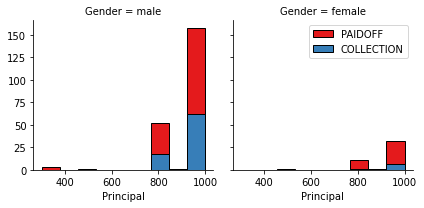

In [ ]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

#### Visualização por sexo e idade

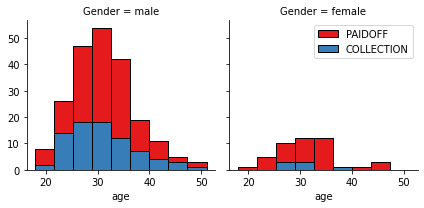

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Afim de quantificarmos esses dados podemos agrupor os status de pagamento de acordo com o sexo do solicitante.

In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Percebe-se que as mulheres tendem a pagar mais rápido seus empréstimos. Para facilitar nossas futuras análises é interessante separarmos homems e mulheres, atribuindo-os as variáveis "O" e "1" respectivamente.

In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

TypeError: ignored

#### Visualização por sexo e dia da semana

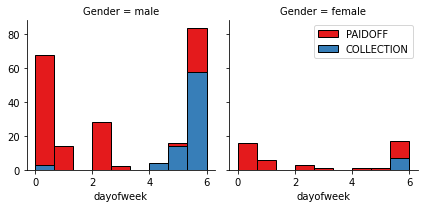

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Pelo gráfico acima é perceptível que o final de semana é o mais própicio para o pagamento do empréstimo.

#### Visualização por sexo e mês

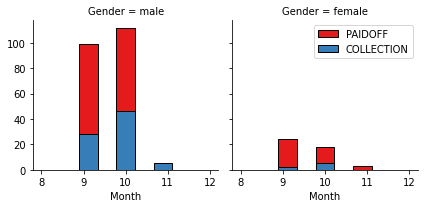

In [ ]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Pelo gráfico acima é perceptível que o mês de setembro é o mais própicio para o pagamento do empréstimo.

Com as considerações acima, é interessante separarmos nossos valores de domingo a quarta-feira (0 à 3) e de quinta-feira a sábado (4 à 6). Para isso, será definido que valores menores ou iguais a 3 serão "0" e valores maiores que 3 serão "1".

In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

Feita as mudanças julgadas necessárias, é interessante levantar o período em dias para o vencimento do pagamento do empréstimo, para isso podemos usar:

In [ ]:
df['deadline']=df['due_date']-df['effective_date']
df['deadline']=df['deadline'].dt.days
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14
3,3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29
4,4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29


Outro dado que talvez traga informações interessantes seja o nível de educação atual do solicitante de empréstimo. Para isso podemos analisar quandos devedores existe em cada nível.

In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Chama a atenção o fato de Mestrado ou acima terem exatamente 50% em cada status.

In [ ]:
len(df[df.education=='Master or Above'])

2

A partir da tabela acima verificamos que mais uma possibilidade de simplificação para o modelo. A divisão da aba educação em 3: Bacharel, Ensino médio ou inferior e Graduando. Mestrados e acimas podem ser desconsiderados devido sua falta de significância neste banco de dados ( temos apenas duas, um devedor e um já quitado).

In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Para manter o padrão, podemos aplicar o mesmo padrão para de 0 e 1 para devedor ou quitado.

SyntaxError: ignored

#Matriz de correlação e definição das Features

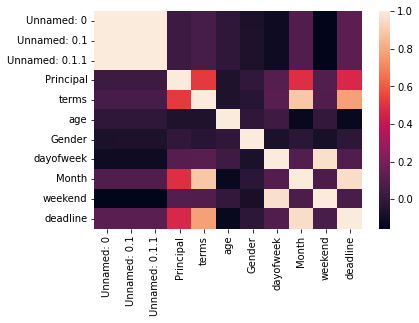

In [ ]:
sns.heatmap(df.corr())

Com base no heatmap acima podemos definir nossa matriz como [0;5] e para manter o padrão, podemos utilizar 0 e 1 para quitado ou devedor respectivamente.

In [ ]:
X = Feature
X[0:5]
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0])

#Normalizando nosso banco de dados após as correções e considerações acimas

In [ ]:
X= preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

Importando as métricas de score do sklearn

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

Definindo os dados que serão utilizados para treinamento do modelo e criando um dicionário para manter os registros, que no final será utilizado para definir qual deverá ser utilizada para esta aplicação.

In [ ]:
X_train = X
y_train= y
trainScores={}

#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

bestScore=0.0
accList=[]

for k in range(3,12):
    
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    # using 10 fold cross validation for scoring the classifier's accuracy
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score=scores.mean()
    accList.append(score)
    
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
        
print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
clf_knn=best_clf

Best K is : 8 | Cross validation Accuracy : 0.7550420168067227


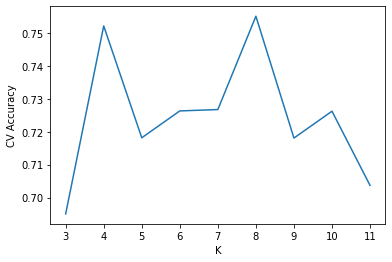

In [ ]:
plt.plot(range(3,12),accList)
plt.xlabel('K')
plt.ylabel('CV Accuracy')
plt.show()

In [ ]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)

trainScores['KNN-jaccard']=jaccard_score(y_train, y_pred)
trainScores['KNN-f1-score']=f1_score(y_train, y_pred, average='weighted')  

trainScores

{'KNN-f1-score': 0.7557778341903834, 'KNN-jaccard': 0.26}

# Árvore de decisão

In [ ]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

y_pred=clf_tree.predict(X_train)

In [ ]:
trainScores['Tree-jaccard']=jaccard_score(y_train, y_pred)
trainScores['Tree-f1-score']=f1_score(y_train, y_pred, average='weighted')  

trainScores

{'KNN-f1-score': 0.7557778341903834,
 'KNN-jaccard': 0.26,
 'Tree-f1-score': 0.924927020820985,
 'Tree-jaccard': 0.7222222222222222}

##Para visualizarmos a árvore de decisão

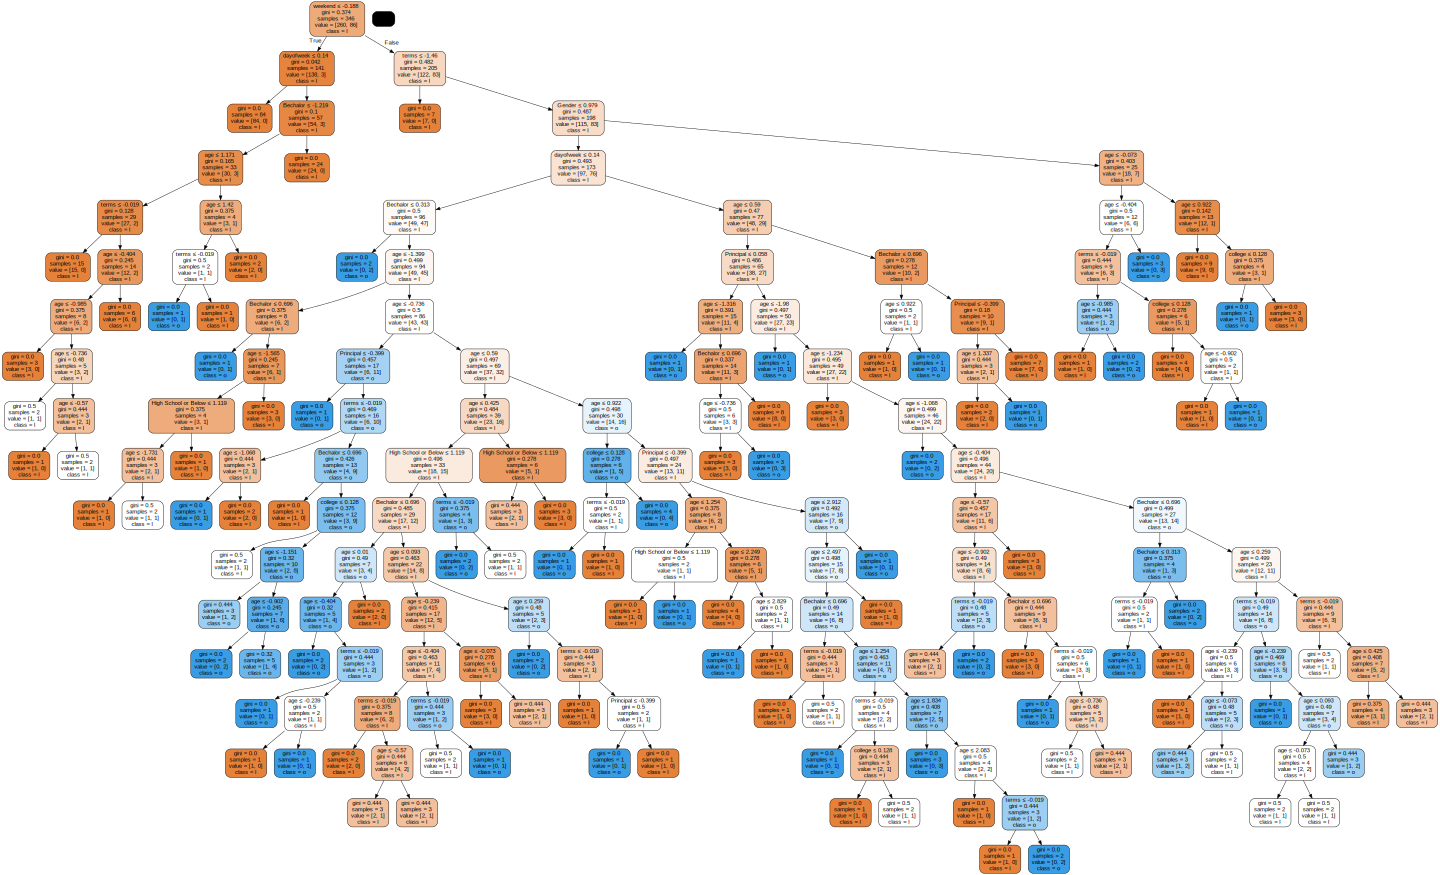

In [ ]:
!pip install graphviz
!pip install pydotplus
import graphviz 
import pydotplus

dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                     feature_names=['Principal',
                                    'terms','age',
                                    'Gender',
                                    'weekend',
                                    'Bechalor',
                                    'High School or Below',
                                    'college',
                                    'dayofweek',
                                     #'deadline'
#                                     ,'Month'
                                   ],  
                     class_names='loan_status',  
                     filled=True, rounded=True,  
                     special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"20!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph 

#Máquina de vetores de suporte

In [ ]:
y_train=y_train.astype(float)

In [ ]:
from sklearn import svm

clf_svm = svm.LinearSVC(random_state=7)
clf_svm.fit(X_train, y_train)  

y_pred=clf_svm.predict(X_train)

In [ ]:
trainScores['SVM-jaccard']=jaccard_score(y_train, y_pred)
trainScores['SVM-f1-score']=f1_score(y_train, y_pred, average='weighted')  

trainScores

{'KNN-f1-score': 0.7557778341903834,
 'KNN-jaccard': 0.26,
 'SVM-f1-score': 0.6689062277741139,
 'SVM-jaccard': 0.054945054945054944,
 'Tree-f1-score': 0.924927020820985,
 'Tree-jaccard': 0.7222222222222222}

#Regressão logística

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [ ]:
trainScores['LogReg-jaccard']=jaccard_score(y_train, y_pred)
trainScores['LogReg-f1-score']=f1_score(y_train, y_pred, average='weighted')  
trainScores['LogReg-logLoss']=log_loss(y_train, y_proba)

trainScores

{'KNN-f1-score': 0.7557778341903834,
 'KNN-jaccard': 0.26,
 'LogReg-f1-score': 0.7088399037150602,
 'LogReg-jaccard': 0.14583333333333334,
 'LogReg-logLoss': 0.43174993676801543,
 'SVM-f1-score': 0.6689062277741139,
 'SVM-jaccard': 0.054945054945054944,
 'Tree-f1-score': 0.924927020820985,
 'Tree-jaccard': 0.7222222222222222}

#Etapa III

Treinado os modelos chegou o momento de o aplicarmos na prática. Para isso, iremos fazer upload de uma base de dados no mesmo formato daquela utilizada para treinar os modelos. Não será utilizada a mesma base de dados afim de garantir o funcionamento dos modelos em informações desconhecidas por eles.

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-11-21 22:59:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-11-21 22:59:39 (644 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


Realizando as mesmas modificações que foram feitas na base de dados de treinamento

In [ ]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# test_df['Month'] = test_df.due_date.dt.month 

# test_df['deadline']=test_df['due_date']-test_df['effective_date']
# test_df['deadline']=test_df['deadline'].dt.days

Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X)

In [ ]:
testScores={}

#KNN

KNN(K — Nearest Neighbors) é um dos muitos algoritmos ( de aprendizagem supervisionada ) usado no campo de data mining e machine learning, ele é um classificador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. O treinamento é formado por vetores de n dimensões.

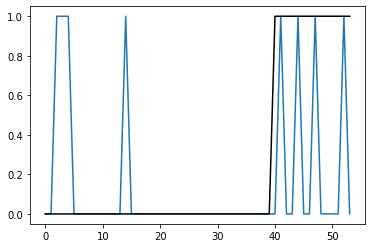

In [ ]:
knn_pred=clf_knn.predict(testX)
testScores['KNN-jaccard']=jaccard_score(testy, knn_pred)
testScores['KNN-f1-score']=f1_score(testy, knn_pred, average='weighted')

plt.plot(knn_pred)
plt.plot(testy, 'k')

#Árvore de decisão

A árvore de decisão é um tipo de algoritmo de apoio, cuja dinâmica de funcionamento é baseada em um gráfico ou modelo de decisões alinhado com as suas possíveis consequências. Além disso, o sistema de árvore leva em consideração resultados de eventos fortuitos, os custos e utilidades dos recursos. Sob a ótica da tomada de decisões de um negócio, a árvore de decisões é representada por um número mínimo de perguntas. Com base nas respostas, avalia-se a probabilidade de tomar decisões acertadas. O objetivo desse método é abordar a sistemática dos problemas, a fim de que se chegue à conclusão mais lógica possível. 

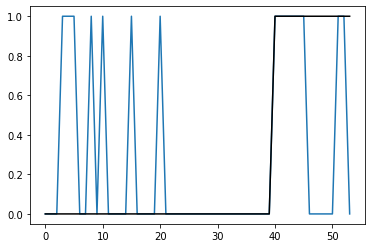

In [ ]:
tree_pred=clf_tree.predict(testX)
testScores['Tree-jaccard']=jaccard_score(testy, tree_pred)
testScores['Tree-f1-score']=f1_score(testy, tree_pred, average='weighted')

plt.plot(tree_pred)
plt.plot(testy, 'k')

#Support Vector Machine (SVM)

O Support Vector Machine (SVM) é um algoritmo binário de classificação. A metodologia é utilizada quando preciso desmembrar dois tipos de situações, que são linearmente separáveis. Com essa escala, podemos resolver diversos tipos de problemas. O SVM já foi aproveitado, por exemplo, para reconhecimento de site de splice humano, detecção de gênero a partir de imagens, publicidades em displays, entre outras tarefas mais complexas.




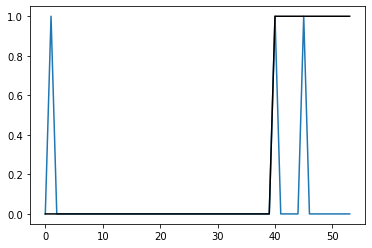

In [ ]:
svm_pred=clf_svm.predict(testX)
testScores['SVM-jaccard']=jaccard_score(testy, svm_pred)
testScores['SVM-f1-score']=f1_score(testy, svm_pred, average='weighted')

plt.plot(svm_pred)
plt.plot(testy, 'k')

#Regressão Logística

A regressão logística é o algoritmo voltado para a medir a relação entre uma variável categórica e outras variáveis independentes. Uma forma estatística para modelar resultados binomiais. Na prática, esse poderoso algoritmo pode ser empregado em aplicações reais, como


*   previsão de receitas de determinado produto;
*   pontuação de crédito
*   mensuração do índice de sucesso das campanhas de marketing, entre outras.

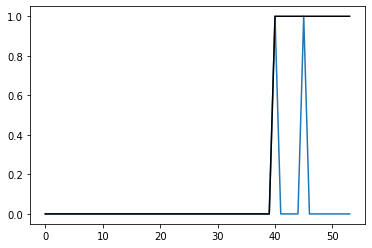

In [ ]:
log_pred=clf_log.predict(testX)
proba=clf_log.predict_proba(testX)
testScores['LogReg-jaccard']=jaccard_score(testy, log_pred)
testScores['LogReg-f1-score']=f1_score(testy, log_pred, average='weighted')  
testScores['LogReg-logLoss']=log_loss(testy, proba)

plt.plot(log_pred)
plt.plot(testy, 'k')

In [ ]:
print(testy)
print(log_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


No handles with labels found to put in legend.


<BarContainer object of 9 artists>

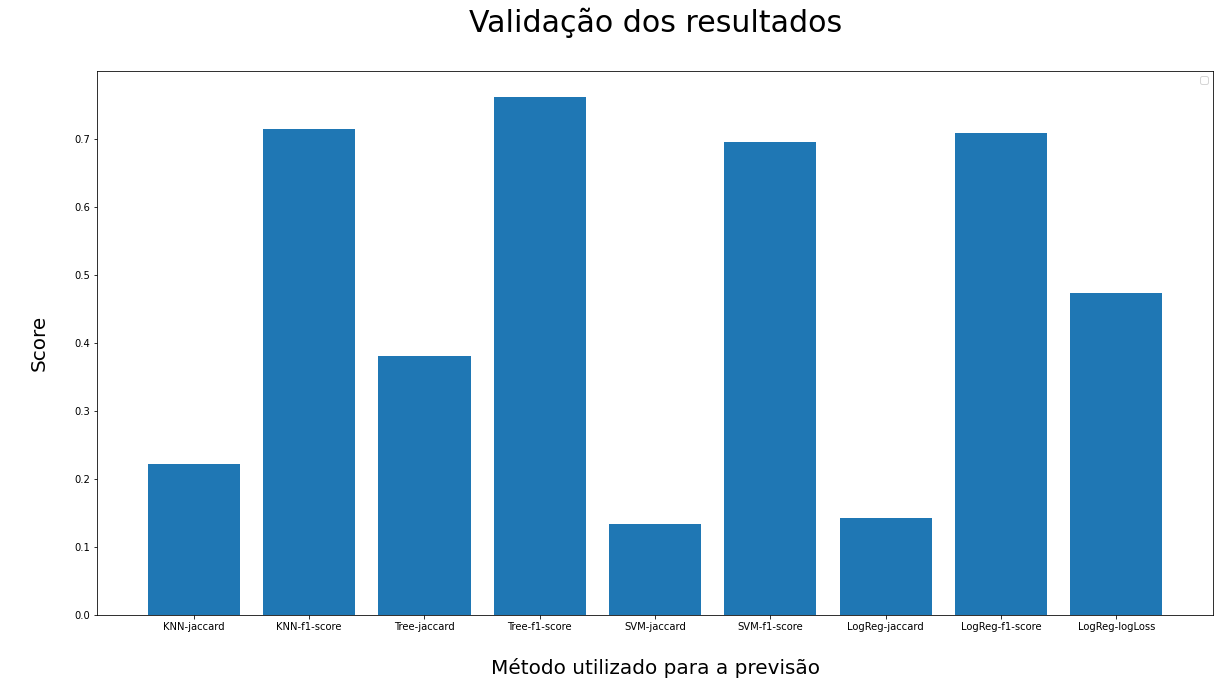

In [ ]:
keys = testScores.keys()
values = testScores.values()

plt.figure(figsize=(20, 10))
plt.xlabel('\nMétodo utilizado para a previsão', fontsize=20)
plt.ylabel('\nScore\n', fontsize=20)
plt.title('Validação dos resultados\n', fontsize=30)
plt.legend(fontsize=10)

plt.bar(keys, values)

# Etapa IV

Socialização a ser realizada no dia 29/11/2021 via Teams.